In [1]:
import numpy as np
import pandas as pd

from sklearn import datasets

import collections

import seaborn

import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

## 1- Implementation

In [2]:
class MyDBSCAN():
    
    def __init__(self, min_pts=3, eps=.3):
        self.min_pts = min_pts
        self.eps = eps
        self.dict_cluster = {}
    
    def neigh_eps(self, x_point, points, eps):
        dist = np.linalg.norm(x_point-points, axis=1)
        return list(np.where(dist<=eps)[0])
    
    def expand_cluster(self, points, idx_point, idx_neigh, cluster_id, idx_points_visited):
        self.dict_cluster[idx_point] = cluster_id
        neigh_mutable = idx_neigh.copy()
        for idx_n in neigh_mutable: # mutable list! it allows to grow the cluster
            if not idx_points_visited[idx_n]:
                idx_points_visited[idx_n] = True
                idx_neigh_neigh = self.neigh_eps(points[idx_n], points, self.eps)
                if len(idx_neigh_neigh)>=self.min_pts:
                    [neigh_mutable.append(i) for i in idx_neigh_neigh if i not in neigh_mutable]
            if idx_n not in self.dict_cluster.keys() or self.dict_cluster[idx_n]==-1:
                self.dict_cluster[idx_n] = cluster_id
        return idx_points_visited
        
    
    def predict_cluster(self, data):
        points = np.array(data)
        idx_points_visited = np.full(len(points), False) # all points are unvisited
        cluster_id = 0
        while(len(np.where(idx_points_visited==False)[0])!=0): # while there is at least one unvisited point
            idx_point = np.where(idx_points_visited==False)[0][0]
            idx_points_visited[idx_point] = True
            idx_neigh = self.neigh_eps(points[idx_point], points, self.eps)
            if len(idx_neigh)<self.min_pts:
                self.dict_cluster[idx_point] = -1 # the point is classified as noise
            else:
                cluster_id += 1
                # go through neighbors of neighbors
                idx_points_visited = self.expand_cluster( 
                               points, 
                               idx_point, 
                               idx_neigh,
                               cluster_id,
                               idx_points_visited)
        od = collections.OrderedDict(sorted(self.dict_cluster.items()))
        return [od[key] for key in od.keys()]

In [5]:
def dbscanEps(X, min_samples):
    n_neighbors = min_samples
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    k_dist = np.apply_along_axis(lambda x: x[n_neighbors-1], axis=1, arr=distances)
    k_dist_sorted = -np.sort(-k_dist)
    diff_extreme = abs(k_dist_sorted[0]-k_dist_sorted[len(k_dist_sorted)-1])/len(k_dist_sorted)
    k_dist_diff = abs(np.diff(k_dist_sorted))
    idx_threshold = (np.abs(k_dist_diff - diff_extreme)).argmin()
    plt.figure(figsize=(10, 4))
    plt.plot(np.arange(1,len(k_dist_sorted)+1), k_dist_sorted)
    plt.title('sorted k-dist graph')
    eps = k_dist_sorted[idx_threshold]
    plt.plot(np.arange(1,len(k_dist_sorted)+1)[idx_threshold], k_dist_sorted[idx_threshold], "o", color='r')
    return eps

## 2- Comparison with scikit-learn

Manual implementation (cluster repartition): [22  5  3]
Scikit-learn implementation (cluster repartition): [22  5  3]
The two implementations give the same results!


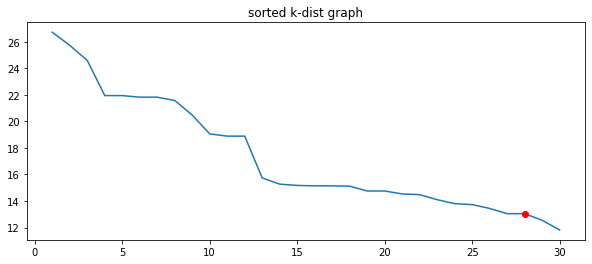

In [6]:
n_samples = 30
n_dim = 5
rnd = np.random.RandomState(0)
# data = datasets.make_moons(n_samples=n_samples, noise=0.3, random_state=0)[0]
data = rnd.normal(3,10,(n_samples ,n_dim))

df = pd.DataFrame(data)
min_samples = 3
eps = dbscanEps(data, min_samples)

# My implementation
dbscan_manual = MyDBSCAN(min_pts=min_samples, eps=eps)
cluster_res_manual = dbscan_manual.predict_cluster(data)

# Scikit learn
dbscan_sklearn = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
cluster_res_sklearn = dbscan_sklearn.labels_

df['cluster_manual'] = cluster_res_manual
df['cluster_manual'] = df['cluster_manual'].astype(str)
df['cluster_sklearn'] = cluster_res_sklearn
df['cluster_sklearn'] = df['cluster_sklearn'].astype(str)

manual_split = df['cluster_manual'].value_counts().values
print('Manual implementation (cluster repartition): {}'.format(manual_split))
sklearn_split = df['cluster_manual'].value_counts().values
print('Scikit-learn implementation (cluster repartition): {}'.format(sklearn_split))

match = True
for i in range(len(manual_split)):
    if manual_split[i] != sklearn_split[i]:
        match = False
if not match:
    print('The two methods doesn''t give the same results!')
else:
    print('The two implementations give the same results!')

## 3- Comparison with scikit-learn (2D)

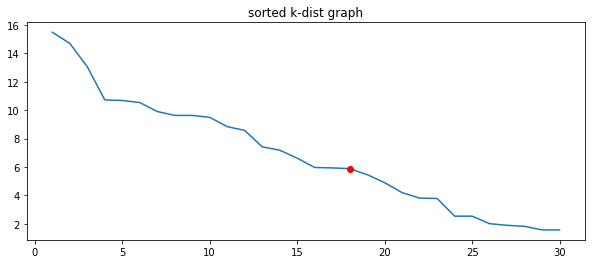

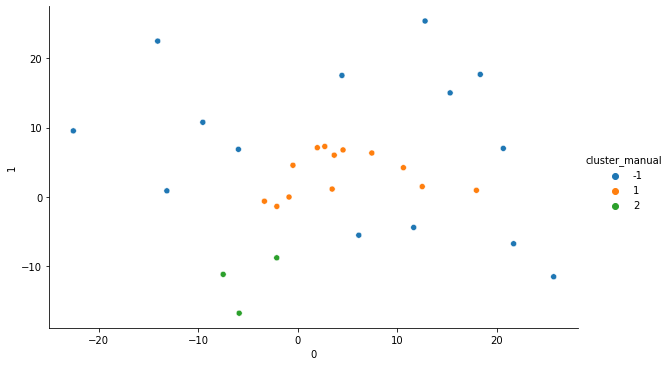

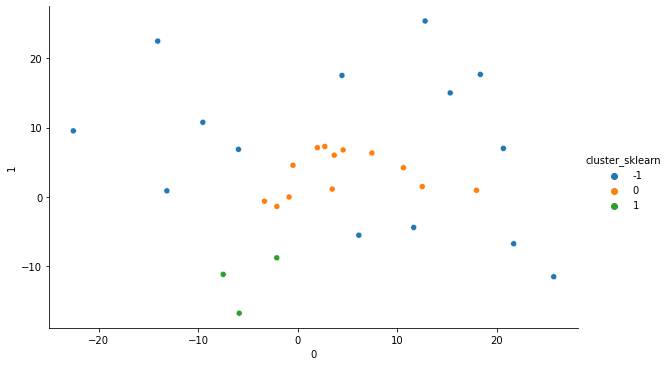

In [7]:
n_samples = 30
n_dim = 2
rnd = np.random.RandomState(0)
# data = datasets.make_moons(n_samples=n_samples, noise=0.3, random_state=0)[0]
data = rnd.normal(3,10,(n_samples ,n_dim))

df = pd.DataFrame(data)
min_samples = 3
eps = dbscanEps(data, min_samples)

# My implementation
dbscan_manual = MyDBSCAN(min_pts=min_samples, eps=eps)
cluster_res_manual = dbscan_manual.predict_cluster(data)

# Scikit learn
dbscan_sklearn = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
cluster_res_sklearn = dbscan_sklearn.labels_

df['cluster_manual'] = cluster_res_manual
df['cluster_manual'] = df['cluster_manual'].astype(str)
df['cluster_sklearn'] = cluster_res_sklearn
df['cluster_sklearn'] = df['cluster_sklearn'].astype(str)

seaborn.relplot(data=df, x=0, y=1, hue='cluster_manual', aspect=1.61)
plt.show()

seaborn.relplot(data=df, x=0, y=1, hue='cluster_sklearn', aspect=1.61)
plt.show()